In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
plt.ion()


import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed

from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils
from graspologic.embed import AdjacencySpectralEmbed
from scipy.linalg import orthogonal_procrustes
from graspologic.plot import heatmap
from sklearn.manifold import Isomap
#import piecewise_regression
from sklearn.linear_model import LinearRegression


#from kneed import DataGenerator, KneeLocator

def filter_matrix_TC(data, well):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well]['win_0']['adj_matrix_predicted']
    votes = data[well]['win_0']['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well]['win_0']['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix


import warnings

def find_optimal_neighbors(X):
    n_neighbors = 2
    while True:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("error")
                isomap = Isomap(n_neighbors=n_neighbors)
                isomap.fit(X)
                print(f"Successful with n_neighbors={n_neighbors}")
                return n_neighbors
        except Warning as w:
            print(f"Warning encountered with n_neighbors={n_neighbors}: {w}")
            n_neighbors += 1




from scipy.stats import norm

def get_elbows(dat, n=3, threshold=False, plot=True, main=""):
    """
    Given a decreasingly sorted vector, return the given number of elbows.

    Args:
        dat: an input vector (e.g. a vector of standard deviations) or an input feature matrix.
        n: the number of returned elbows.
        threshold: either False or a number. If threshold is a number, then all
                   the elements in dat that are not larger than the threshold will be ignored.
        plot: logical. When True, it depicts a scree plot with highlighted elbows.
        main: title for the plot.

    Returns:
        q: a list of length n containing the positions of the elbows.
    """
    
    if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
        d = np.sort(np.std(dat, axis=0))[::-1]
    else:
        d = np.sort(dat)[::-1]

    if threshold is not False:
        d = d[d > threshold]

    p = len(d)
    if p == 0:
        raise ValueError(f"d must have elements that are larger than the threshold {threshold}!")

    lq = np.zeros(p)  # log likelihood, function of q
    for q in range(p):
        mu1 = np.mean(d[:q+1])
        mu2 = np.mean(d[q+1:]) if q < p-1 else np.nan
        sigma2 = (np.sum((d[:q+1] - mu1)**2) + np.sum((d[q+1:] - mu2)**2)) / (p - 1 - (q < p-1))
        lq[q] = (np.sum(norm.logpdf(d[:q+1], mu1, np.sqrt(sigma2))) + 
                 np.sum(norm.logpdf(d[q+1:], mu2, np.sqrt(sigma2))))

    q = [np.argmax(lq)]
    if n > 1 and q[0] < (p - 1):
        q.extend([q[0] + 1 + el for el in get_elbows(d[q[0]+1:], n-1, plot=False)])

    if plot:
        if isinstance(dat, np.ndarray) and len(dat.shape) > 1:
            sdv = d
            plt.plot(sdv, marker='o')
            plt.xlabel("dim")
            plt.ylabel("stdev")
            plt.title(main)
            plt.scatter(q, sdv[q], s=100, color='red')
        else:
            plt.plot(dat, marker='o')
            plt.title(main)
            plt.scatter(q, dat[q], s=100, color='red')
        plt.show()

    return q



In [4]:
root_dr = r'/cis/project/organoid/2024May28 No window data /OneDrive_1_6-17-2024/TimeCourseData_ecr_results/'

os.chdir(root_dr)

dr1 = 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/'
#dr2 = 'Raw Data Week 9.5 to 12.5 (run 6 and 7)/Run 7/'

In [6]:
filenames=os.listdir(dr1)
filenames.pop(2)
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('DIV ')[1]))
#sorted_filenames_updated = [filename + '/data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]
sorted_filenames_updated1 = [dr1+filename + '/data.raw_20240521_17h07m.pkl' for filename in sorted_filenames]
#sorted_filenames_updated2 = [dr2+filename + '/data.raw_20240521_17h07m.pkl' for filename in sorted_filenames]
#sorted_filenames_updated = [filename + '/M05912data.raw_20240326_18h20m.pkl' for filename in sorted_filenames]

#time_points = [int(x.split('DIV ')[1]) for x in sorted_filenames]

#time_points = [int(x.split('DIV ')[1])+21 for x in sorted_filenames]

sorted_filenames_updated=sorted_filenames_updated1#+sorted_filenames_updated2
sorted_filenames_updated


['Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 3/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 5/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 7/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 9/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 11/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 13/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 15/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 17/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 19/data.raw_20240521_17h07m.pkl',
 'Raw Data Week 5.5 to 8.5 (run 8 and LD)/Run 8/DIV 21/data.raw_20240521_17h07m.pkl']

In [7]:
## This shows that the data doesn't have window 
with open(sorted_filenames_updated[0], 'rb') as f:
    data = pkl.load(f)
data['well000'].keys()

dict_keys(['spike_amp_thresh', 'channel_numbers', 'channel_spikes_per_sec', 'win_0'])

In [8]:
well='well004'

In [9]:
## read in all the time series of graphs
all_adj = []
num_vertices = []
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    adj = filter_matrix_TC(data, well)
    all_adj.append(adj)
    num_vertices.append(adj.shape[0])

#total_edges = 0
#total_matrices = len(all_adj)

#for adj in all_adj:
#    total_edges += adj.sum()

#average_edges = total_edges / total_matrices
#print("Average number of edges:", average_edges)

In [10]:
import igraph as ig

lcc_sizes = []

for adj in all_adj:
    # Create igraph from adjacency matrix
    adj_symm = (adj + adj.T) / 2
    adj_symm = (adj_symm > 0).astype(int)  # Convert to binary
    
    # Create igraph from adjacency matrix
    g = ig.Graph.Adjacency(adj_symm.tolist(), mode="undirected")
    
    # Find the largest connected component
    components = g.clusters()
    lcc = components.giant()
    
    # Get the number of nodes in the LCC
    lcc_size = lcc.vcount()
    lcc_sizes.append(lcc_size)
    
    print(f"LCC size: {lcc_size}")

print(f"\nAverage LCC size: {np.mean(lcc_sizes)}")

/tmp/ipykernel_602796/1658663439.py:14: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  components = g.clusters()


LCC size: 1
LCC size: 50
LCC size: 90
LCC size: 120
LCC size: 249
LCC size: 488
LCC size: 805
LCC size: 877
LCC size: 965
LCC size: 938

Average LCC size: 458.3


/tmp/ipykernel_602796/647324088.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/647324088.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/647324088.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/647324088.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/647324088.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/647324088.py:22: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/647324088.py

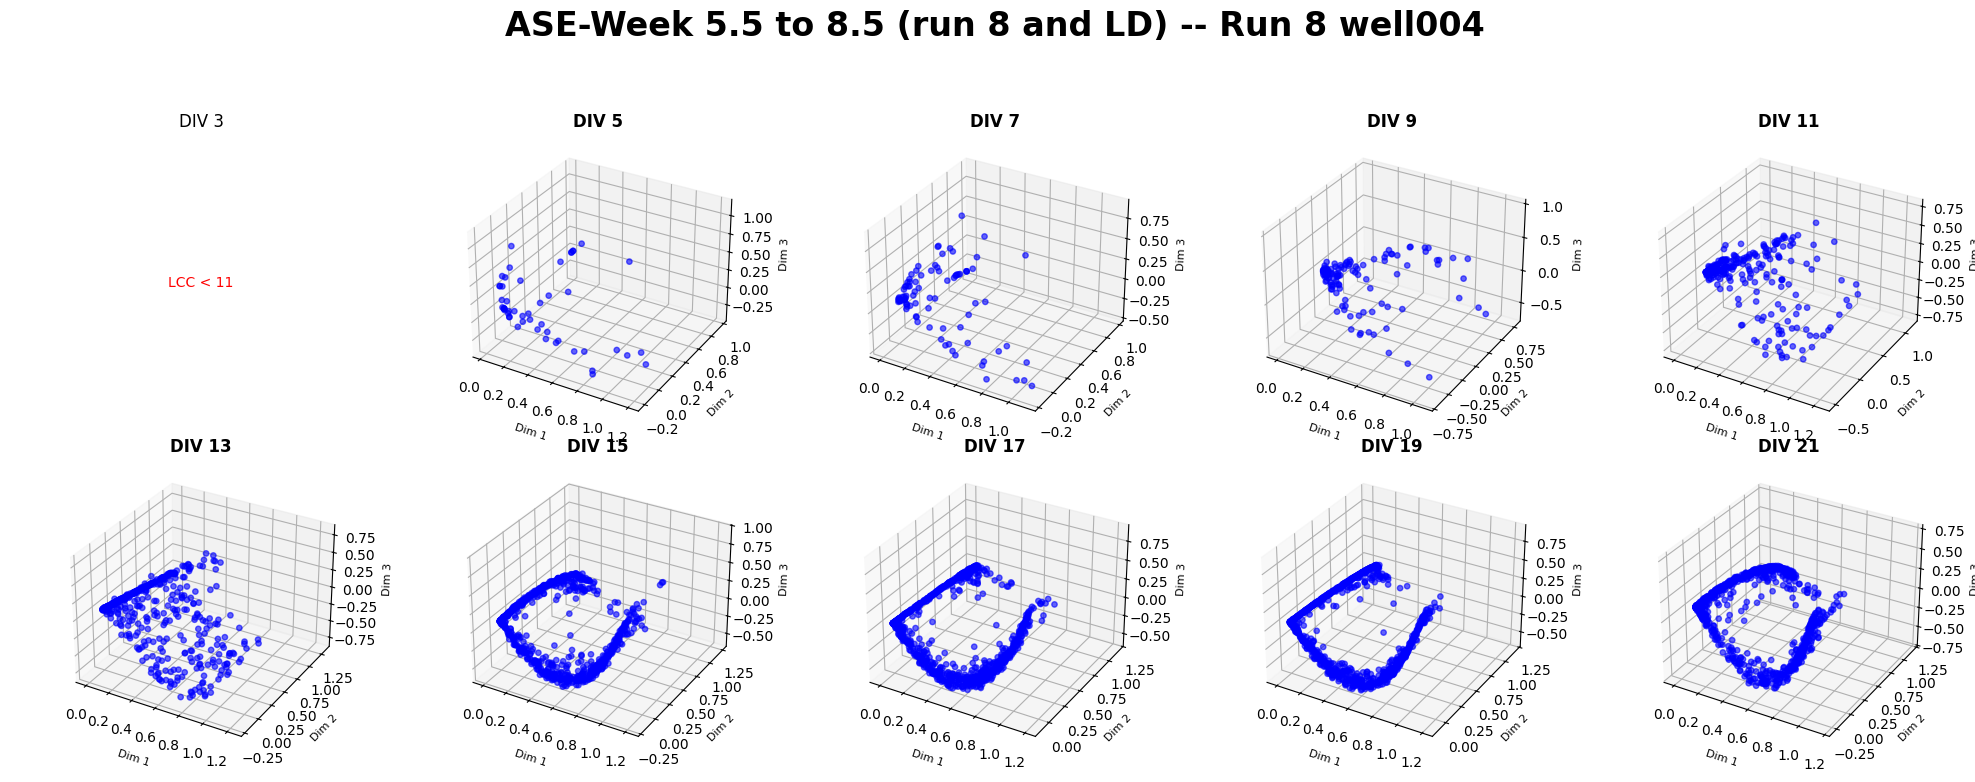

In [11]:
# --- Setup Titles and Figure ---
# Generate titles: DIV 3, DIV 5, ..., DIV 21
div_titles = [f"DIV {x}" for x in range(3, 23, 2)]

# Create one large figure for the 2x5 grid
fig = plt.figure(figsize=(20, 8)) 
fig.suptitle(f"ASE-Week 5.5 to 8.5 (run 8 and LD) -- Run 8 {well}", fontsize=24, fontweight='bold')
# Initialize the embedder
ase = AdjacencySpectralEmbed(n_components=10, check_lcc=False)

# Limit loop to 10 items to fit the 2x5 grid (DIV 3 to 21)
for i in range(min(len(all_adj), 10)):
    
    adj = all_adj[i]
    current_title = f"{div_titles[i]}"
    
    # 1. Symmetrize & Extract LCC
    # Force symmetry to avoid igraph errors
    adj_symm = ((adj + adj.T) > 0).astype(int)
    
    g = ig.Graph.Adjacency(adj_symm.tolist(), mode="undirected")
    lcc = g.clusters().giant()
    
    # 2. Check LCC size
    # We must determine the subplot type (2D/3D) later, but if we skip, 
    # we default to 2D just to print the error message.
    if lcc.vcount() < 11:
        ax = fig.add_subplot(2, 5, i + 1)
        ax.text(0.5, 0.5, "LCC < 11", ha='center', va='center', color='red')
        ax.set_title(current_title)
        ax.axis('off')
        continue

    # 3. Run ASE
    mat_lcc = np.array(lcc.get_adjacency().data)
    
    try:
        Xhat = ase.fit_transform(mat_lcc)
        evals = ase.singular_values_
    except ValueError:
        # Error handling subplot
        ax = fig.add_subplot(2, 5, i + 1)
        ax.text(0.5, 0.5, "ASE Failed", ha='center', va='center', color='red')
        ax.axis('off')
        continue

    # 4. Determine Dimension (Elbows)
    elbow_indices = get_elbows(evals, n=3, plot=False)
    
    if len(elbow_indices) >= 2:
        embedding_dim = elbow_indices[1] + 1 
    elif len(elbow_indices) == 1:
        embedding_dim = elbow_indices[0] + 1
    else:
        embedding_dim = 2
        
    embedding_dim = 3 

    # 5. Dynamic Plotting (2D vs 3D)
    # We choose the projection type based on the calculated dimension
    
    if embedding_dim >= 3:
        # Add 3D subplot
        ax = fig.add_subplot(2, 5, i + 1, projection='3d')
        ax.scatter(Xhat[:, 0], Xhat[:, 1], Xhat[:, 2], c='blue', alpha=0.6, s=15)
        ax.set_xlabel("Dim 1", fontsize=8)
        ax.set_ylabel("Dim 2", fontsize=8)
        ax.set_zlabel("Dim 3", fontsize=8)
    else:
        # Add 2D subplot (standard)
        ax = fig.add_subplot(2, 5, i + 1)
        
        if embedding_dim < 2:
            ax.text(0.5, 0.5, f"Dim < 2 ({embedding_dim})", color="orange", ha='center')
            ax.axis('off')
        else:
            ax.scatter(Xhat[:, 0], Xhat[:, 1], c='blue', alpha=0.6, s=15)
            ax.set_xlabel("Dimension 1", fontsize=8)
            ax.set_ylabel("Dimension 2", fontsize=8)

    ax.set_title(current_title, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [12]:
from graspologic.embed import LaplacianSpectralEmbed

/tmp/ipykernel_602796/2994699939.py:23: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/2994699939.py:23: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/2994699939.py:23: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/2994699939.py:23: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/2994699939.py:23: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/2994699939.py:23: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  lcc = g.clusters().giant()
/tmp/ipykernel_602796/299469

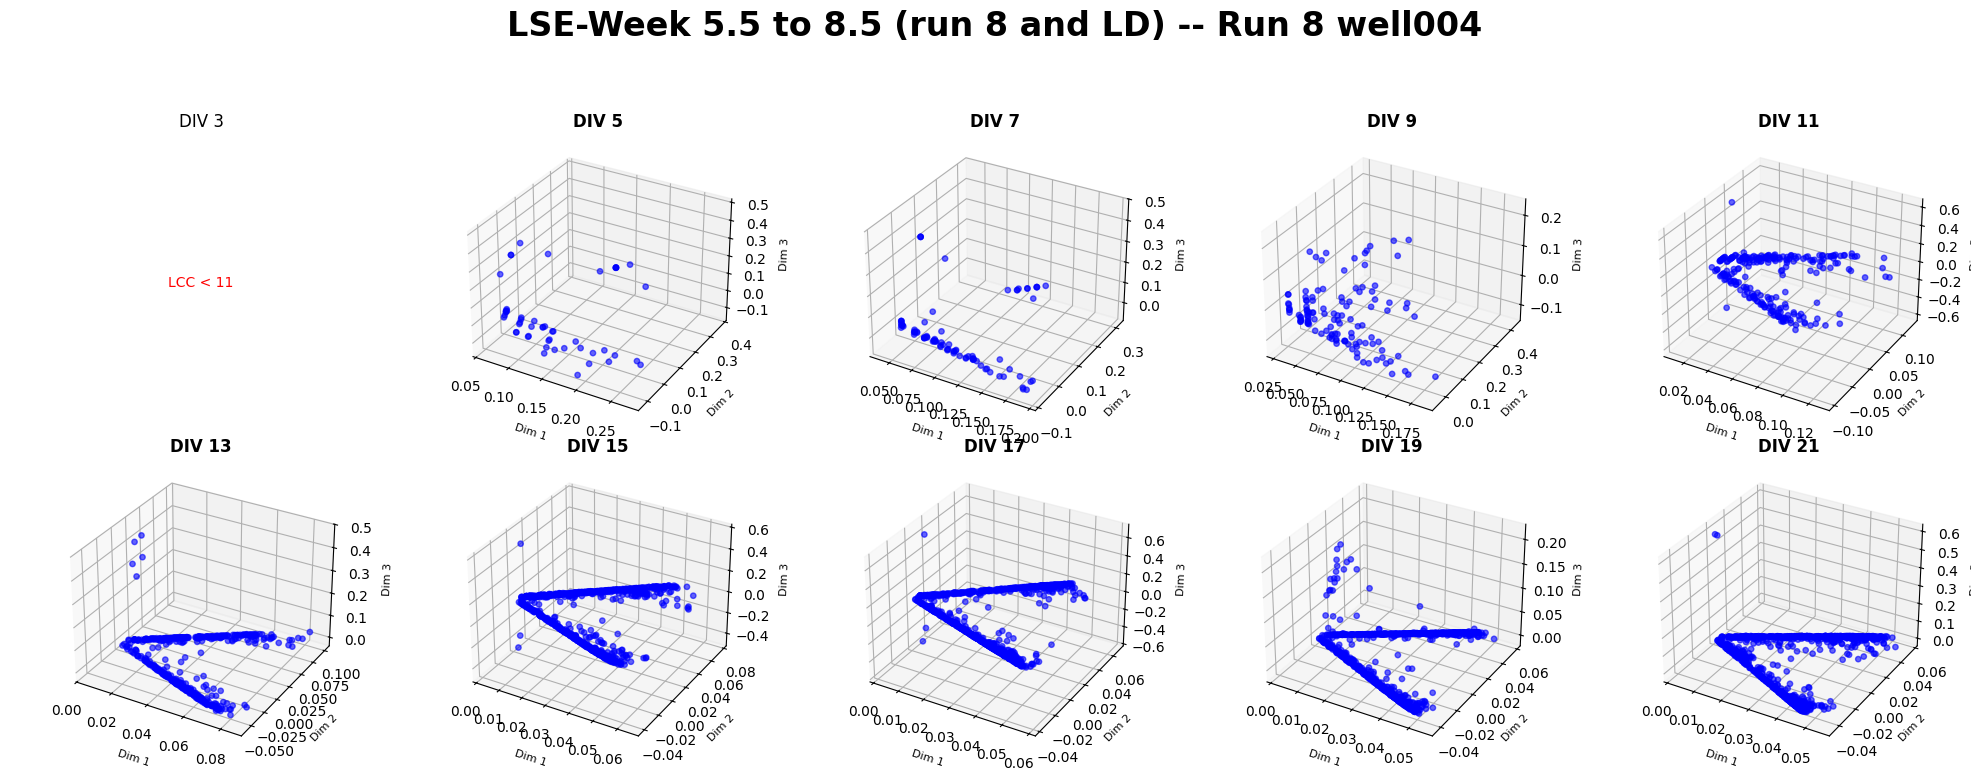

In [14]:
# --- Setup Titles and Figure ---
# Generate titles: DIV 3, DIV 5, ..., DIV 21
div_titles = [f"DIV {x}" for x in range(3, 23, 2)]

# Create one large figure for the 2x5 grid
fig = plt.figure(figsize=(20, 8)) 
fig.suptitle(f"LSE-Week 5.5 to 8.5 (run 8 and LD) -- Run 8 {well}", fontsize=24, fontweight='bold')

# Initialize the embedder (Changed to LaplacianSpectralEmbed)
lse = LaplacianSpectralEmbed(n_components=10, check_lcc=False)

# Limit loop to 10 items to fit the 2x5 grid (DIV 3 to 21)
for i in range(min(len(all_adj), 10)):
    
    adj = all_adj[i]
    current_title = f"{div_titles[i]}"
    
    # 1. Symmetrize & Extract LCC
    # Force symmetry to avoid igraph errors
    adj_symm = ((adj + adj.T) > 0).astype(int)
    
    g = ig.Graph.Adjacency(adj_symm.tolist(), mode="undirected")
    lcc = g.clusters().giant()
    
    # 2. Check LCC size
    # We must determine the subplot type (2D/3D) later, but if we skip, 
    # we default to 2D just to print the error message.
    if lcc.vcount() < 11:
        ax = fig.add_subplot(2, 5, i + 1)
        ax.text(0.5, 0.5, "LCC < 11", ha='center', va='center', color='red')
        ax.set_title(current_title)
        ax.axis('off')
        continue

    # 3. Run LSE (Changed from ASE)
    mat_lcc = np.array(lcc.get_adjacency().data)
    
    try:
        Xhat = lse.fit_transform(mat_lcc)
        evals = lse.singular_values_
    except ValueError:
        # Error handling subplot
        ax = fig.add_subplot(2, 5, i + 1)
        ax.text(0.5, 0.5, "LSE Failed", ha='center', va='center', color='red')
        ax.axis('off')
        continue

    # 4. Determine Dimension (Elbows)
    elbow_indices = get_elbows(evals, n=3, plot=False)
    
    if len(elbow_indices) >= 2:
        embedding_dim = elbow_indices[1] + 1 
    elif len(elbow_indices) == 1:
        embedding_dim = elbow_indices[0] + 1
    else:
        embedding_dim = 2
        
    #embedding_dim = 2

    # 5. Dynamic Plotting (2D vs 3D)
    # We choose the projection type based on the calculated dimension
    
    if embedding_dim >= 3:
        # Add 3D subplot
        ax = fig.add_subplot(2, 5, i + 1, projection='3d')
        ax.scatter(Xhat[:, 0], Xhat[:, 1], Xhat[:, 2], c='blue', alpha=0.6, s=15)
        ax.set_xlabel("Dim 1", fontsize=8)
        ax.set_ylabel("Dim 2", fontsize=8)
        ax.set_zlabel("Dim 3", fontsize=8)
    else:
        # Add 2D subplot (standard)
        ax = fig.add_subplot(2, 5, i + 1)
        
        if embedding_dim < 2:
            ax.text(0.5, 0.5, f"Dim < 2 ({embedding_dim})", color="orange", ha='center')
            ax.axis('off')
        else:
            ax.scatter(Xhat[:, 0], Xhat[:, 1], c='blue', alpha=0.6, s=15)
            ax.set_xlabel("Dimension 1", fontsize=8)
            ax.set_ylabel("Dimension 2", fontsize=8)

    ax.set_title(current_title, fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

/tmp/ipykernel_2584042/2537854641.py:78: DeprecationWarning: Graph.clusters() is deprecated; use Graph.connected_components() instead
  clusters = g.clusters()


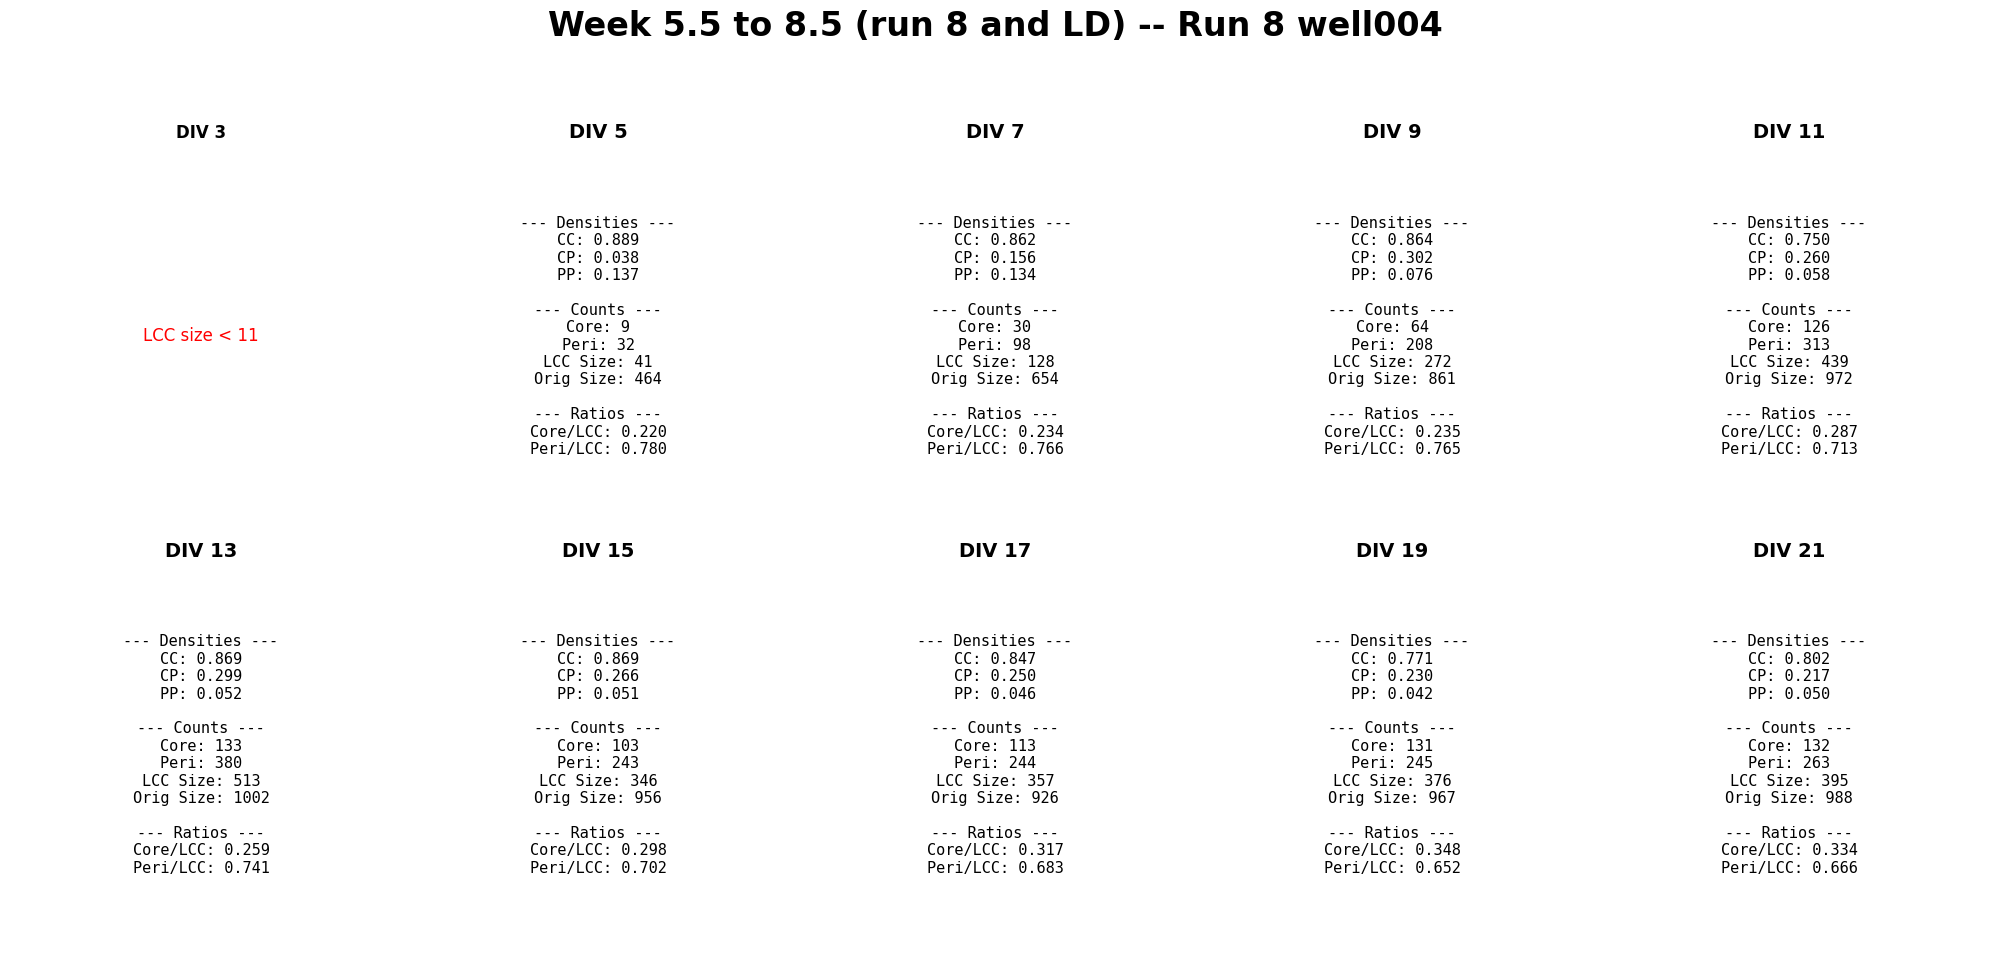

In [79]:
# --- Helper Function: CP Statistics ---
def get_clique_density_stats(adj):
    """
    Calculates Core-Periphery statistics based on max k-core.
    """
    # 1. Convert to igraph for coreness calculation
    # Ensure binary/symmetric
    adj_bin = (adj > 0).astype(int)
    g = ig.Graph.Adjacency(adj_bin.tolist(), mode="undirected")
    
    # 2. Identify Core Nodes (Max Coreness)
    # coreness() returns the k-core number for each vertex
    kc = np.array(g.coreness())
    max_k = np.max(kc) if len(kc) > 0 else 0
    
    # Indices in Python are 0-based
    core_indices = np.where(kc == max_k)[0]
    all_indices = np.arange(adj.shape[0])
    periph_indices = np.setdiff1d(all_indices, core_indices)
    
    n_c = len(core_indices)
    n_p = len(periph_indices)
    
    # 3. Calculate Edges (using numpy slicing)
    # CC (internal core edges) -> sum / 2 for undirected
    if n_c > 1:
        edges_CC = adj[np.ix_(core_indices, core_indices)].sum() / 2
    else:
        edges_CC = 0
        
    # PP (internal periphery edges) -> sum / 2
    if n_p > 1:
        edges_PP = adj[np.ix_(periph_indices, periph_indices)].sum() / 2
    else:
        edges_PP = 0
        
    # CP (edges between core and periphery) -> sum (no division)
    if n_c > 0 and n_p > 0:
        edges_CP = adj[np.ix_(core_indices, periph_indices)].sum()
    else:
        edges_CP = 0
        
    # 4. Calculate Max Possible Edges
    max_CC = n_c * (n_c - 1) / 2
    max_PP = n_p * (n_p - 1) / 2
    max_CP = n_c * n_p
    
    # 5. Calculate Densities
    dens_CC = edges_CC / max_CC if max_CC > 0 else 0
    dens_PP = edges_PP / max_PP if max_PP > 0 else 0
    dens_CP = edges_CP / max_CP if max_CP > 0 else 0
    
    return {
        'dens_CC': dens_CC, 'dens_CP': dens_CP, 'dens_PP': dens_PP,
        'n_core': n_c, 'n_periph': n_p
    }

# --- Main Plotting Loop ---

# Setup Figure: 2 rows, 5 columns
fig = plt.figure(figsize=(20, 10))
div_titles = [f"DIV {x}" for x in range(3, 23, 2)]
fig.suptitle(f"Week 5.5 to 8.5 (run 8 and LD) -- Run 8 {well}", fontsize=24, fontweight='bold')

# Iterate through graphs (limited to first 10 to fit 2x5 grid)
for i in range(min(len(all_adj), 10)):
    
    adj = all_adj[i]
    current_title = f"{div_titles[i]}"
    
    ax = fig.add_subplot(2, 5, i + 1)
    
    # 1. Symmetrize & Extract LCC
    adj_symm = ((adj + adj.T) > 0).astype(int)
    g = ig.Graph.Adjacency(adj_symm.tolist(), mode="undirected")
    
    # Get LCC
    clusters = g.clusters()
    lcc_g = clusters.giant()
    
    n_original = g.vcount()
    n_lcc = lcc_g.vcount()
    
    # 2. Check Size Threshold
    if n_lcc < 11:
        ax.text(0.5, 0.5, "LCC size < 11", color="red", 
                ha='center', va='center', fontsize=12)
        ax.axis('off')
        ax.set_title(current_title, fontweight='bold')
        continue

    # 3. Calculate CP Stats on LCC
    # Convert LCC back to matrix
    mat_lcc = np.array(lcc_g.get_adjacency().data)
    
    try:
        stats = get_clique_density_stats(mat_lcc)
        
        # Calculate Ratios
        ratio_core = stats['n_core'] / n_lcc
        ratio_peri = stats['n_periph'] / n_lcc
        
        # 4. Format Text Output
        # Using a monospaced font string for alignment
        text_str = (
            "--- Densities ---\n"
            f"CC: {stats['dens_CC']:.3f}\n"
            f"CP: {stats['dens_CP']:.3f}\n"
            f"PP: {stats['dens_PP']:.3f}\n\n"
            
            "--- Counts ---\n"
            f"Core: {stats['n_core']}\n"
            f"Peri: {stats['n_periph']}\n"
            f"LCC Size: {n_lcc}\n"
            f"Orig Size: {n_original}\n\n"
            
            "--- Ratios ---\n"
            f"Core/LCC: {ratio_core:.3f}\n"
            f"Peri/LCC: {ratio_peri:.3f}"
        )
        
        # 5. Display Text
        ax.text(0.5, 0.5, text_str, 
                ha='center', va='center', 
                family='monospace', fontsize=11)
        
    except Exception as e:
        ax.text(0.5, 0.5, "Error Calc Stats", color='red', ha='center')
        print(f"Error on {current_title}: {e}")

    # Clean up plot appearance
    ax.axis('off')
    # Optional: Add a bounding box (spine) if you want it to look like a card
    # For now, we leave it clean.
    ax.set_title(current_title, fontweight='bold', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()